In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from mixture_gaussian import data_generator

In [3]:
if torch.cuda.is_available():
    cuda = True
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
else:
    cuda = False

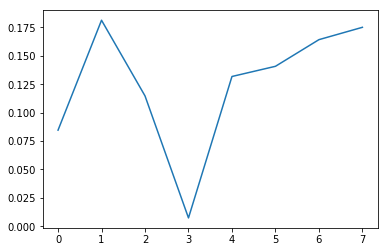

In [4]:
dset = data_generator()
dset.random_distribution()

plt.plot(dset.p)
plt.show()
plt.close()

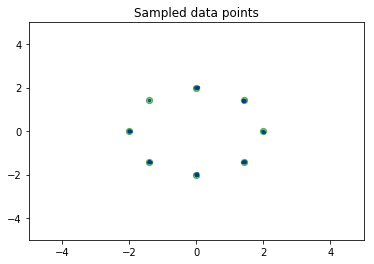

In [5]:
def plot(points, title):

    plt.scatter(points[:, 0], points[:, 1], s=5, c='b', alpha=0.5)
    plt.scatter(dset.centers[:, 0], dset.centers[:, 1], s=40, c='g', alpha=0.5)
    plt.title(title)
    plt.ylim(-5, 5)
    plt.xlim(-5, 5)
    plt.show()
    plt.close()
    
sample_points = dset.sample(100)
plot(sample_points, 'Sampled data points')

In [15]:
# Model params
z_dim = 256
g_inp = z_dim
g_hid = 128
g_out = dset.size

d_inp = g_out
d_hid = 128
d_out = 1

minibatch_size = 512

unrolled_steps = 10
d_learning_rate = 1e-4
g_learning_rate = 1e-3
optim_betas = (0.5, 0.999)
num_iterations = 30000
log_interval = 1000
save_interval = 2000
d_steps = 1  
g_steps = 1

In [16]:
def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')

In [17]:
###### MODELS: Generator model and discriminator model
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(x))
        return F.sigmoid(self.map3(x))
    
    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()  

In [18]:
G = Generator(input_size=g_inp, hidden_size=g_hid, output_size=g_out)
D = Discriminator(input_size=d_inp, hidden_size=d_hid, output_size=d_out)
if cuda:
    G = G.cuda()
    D = D.cuda()
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [19]:
def d_loop():
    # 1. Train D on real+fake
    d_optimizer.zero_grad()

    #  1A: Train D on real
    d_real_data = torch.from_numpy(dset.sample(minibatch_size))
    if cuda:
        d_real_data = d_real_data.cuda()
    d_real_decision = D(d_real_data)
    target = torch.ones_like(d_real_decision)
    if cuda:
        target = target.cuda()
    d_real_error = criterion(d_real_decision, target)  # ones = true

    #  1B: Train D on fake
    d_gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
    if cuda:
        d_gen_input = d_gen_input.cuda()
    #with torch.no_grad():
    d_fake_data = G(d_gen_input)
    d_fake_decision = D(d_fake_data)
    target = torch.zeros_like(d_fake_decision)
    if cuda:
        target = target.cuda()
    d_fake_error = criterion(d_fake_decision, target)  # zeros = fake
    
    d_loss = d_real_error + d_fake_error
    d_loss.backward()
    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
    return d_real_error.cpu().item(), d_fake_error.cpu().item()

In [20]:
def d_unrolled_loop(d_gen_input=None):
    # 1. Train D on real+fake
    d_optimizer.zero_grad()

    #  1A: Train D on real
    d_real_data = torch.from_numpy(dset.sample(minibatch_size))
    if cuda:
        d_real_data = d_real_data.cuda()
    d_real_decision = D(d_real_data)
    target = torch.ones_like(d_real_decision)
    if cuda:
        target = target.cuda()
    d_real_error = criterion(d_real_decision, target)  # ones = true

    #  1B: Train D on fake
    if d_gen_input is None:
        d_gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
    if cuda:
        d_gen_input = d_gen_input.cuda()
    
    with torch.no_grad():
        d_fake_data = G(d_gen_input)
    d_fake_decision = D(d_fake_data)
    target = torch.zeros_like(d_fake_decision)
    if cuda:
        target = target.cuda()
    d_fake_error = criterion(d_fake_decision, target)  # zeros = fake
    
    d_loss = d_real_error + d_fake_error
    d_loss.backward(create_graph=True)
    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
    return d_real_error.cpu().item(), d_fake_error.cpu().item()

In [21]:
def g_loop():
    # 2. Train G on D's response (but DO NOT train D on these labels)
    g_optimizer.zero_grad()

    gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
    if cuda: 
        gen_input = gen_input.cuda()
        
    if unrolled_steps > 0:
        backup = copy.deepcopy(D)
        for i in range(unrolled_steps):
            d_unrolled_loop(d_gen_input=gen_input)
    
    g_fake_data = G(gen_input)
    dg_fake_decision = D(g_fake_data)
    target = torch.ones_like(dg_fake_decision)
    if cuda:
        target = target.cuda()
    g_error = criterion(dg_fake_decision, target)  # we want to fool, so pretend it's all genuine
    g_error.backward()
    g_optimizer.step()  # Only optimizes G's parameters
    
    if unrolled_steps > 0:
        D.load(backup)    
        del backup
    return g_error.cpu().item()

In [22]:
def g_sample():
    with torch.no_grad():
        gen_input = torch.from_numpy(noise_sampler(minibatch_size, g_inp))
        if cuda:
            gen_input = gen_input.cuda()
        g_fake_data = G(gen_input)
    return g_fake_data.cpu().numpy()

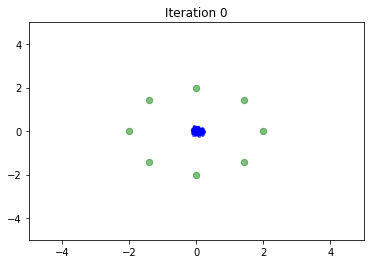

0.7419331073760986 0.6609535217285156 0.7263199090957642


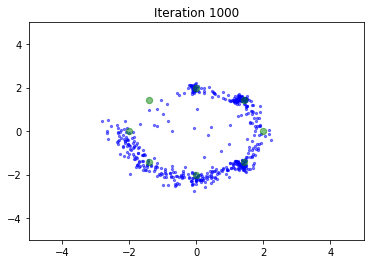

0.6159247159957886 0.626611053943634 0.7820392847061157


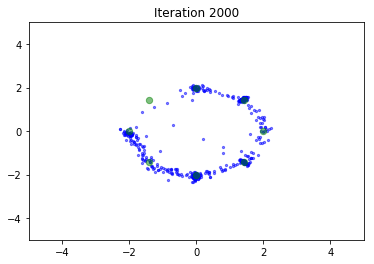

0.5211694240570068 0.5876993536949158 0.9681923985481262


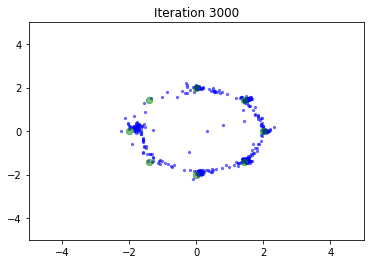

0.5091835856437683 0.48074811697006226 1.1654850244522095


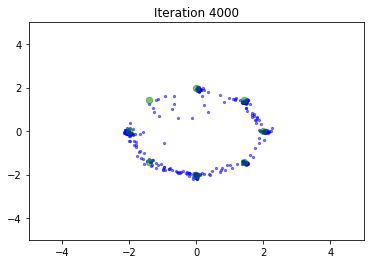

0.4879129230976105 0.5018922090530396 1.3242048025131226


In [ ]:
for it in tqdm_notebook(range(num_iterations)):
    d_infos = []
    for d_index in range(d_steps):
        d_info = d_loop()
        d_infos.append(d_info)
    d_infos = np.mean(d_infos, 0)
    d_real_loss, d_fake_loss = d_infos
    
    g_infos = []
    for g_index in range(g_steps):
        g_info = g_loop()
        g_infos.append(g_info)
    g_infos = np.mean(g_infos)
    g_loss = g_infos
    
    if it % log_interval == 0:
        g_fake_data = g_sample()
        plot(g_fake_data, title='Iteration {}'.format(it))
        print(d_real_loss, d_fake_loss, g_loss)